<a href="https://colab.research.google.com/github/qraxiss/learning-data-science/blob/main/machine-learning/classification/catb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data & Libs

In [ ]:
!pip install catboost

In [78]:
# Libs
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from google.colab import drive
from warnings import filterwarnings
filterwarnings('ignore')

# Data
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/learning-data-science-main/machine-learning/datas/diabetes.csv")
df = df.dropna()
df.index = np.arange(df.shape[0])

# X&y
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Test Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=31)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Model

In [ ]:
cat_model = CatBoostClassifier().fit(X_train, y_train)

# Predict

In [ ]:
basic = accuracy_score(y_test, cat_model.predict(X_test))
cv = cross_val_score(cat_model,X_test,y_test,cv=10).mean()

In [83]:
print("Basic Accuracy Score",basic)
print("CV Accuracy Score",cv)

Basic Accuracy Score 0.7575757575757576
CV Accuracy Score 0.7614130434782609


# Model Tuning

In [ ]:
catb_params = {
    'iterations': [200,500],
    'learning_rate': [0.01,0.05, 0.1],
    'depth': [3,5,8] }

catb = CatBoostClassifier()
catb_cv = GridSearchCV(catb, catb_params, cv = 3, n_jobs = -1, verbose = 2)
catb_cv_model = catb_cv.fit(X_train, y_train)

In [85]:
print("En iyi skor:" + str(catb_cv_model.best_score_))
print("En iyi parametreler: " + str(catb_cv_model.best_params_))
params = pd.Series(catb_cv_model.best_params_)
params

En iyi skor:0.7448676690894968
En iyi parametreler: {'depth': 3, 'iterations': 200, 'learning_rate': 0.05}


depth              3.00
iterations       200.00
learning_rate      0.05
dtype: float64

## Tuned Model

In [ ]:
catb = CatBoostClassifier(depth = int(params[0]), iterations=int(params[1]), learning_rate = float(params[2]))
catb_tuned = catb.fit(X_train, y_train) 

In [ ]:
basic = accuracy_score(y_test, catb_tuned.predict(X_test))
cv = cross_val_score(catb_tuned,X_test,y_test,cv=10).mean()

In [90]:
print("Basic Accuracy Score",basic)
print("CV Accuracy Score",cv)

Basic Accuracy Score 0.7792207792207793
CV Accuracy Score 0.7614130434782609


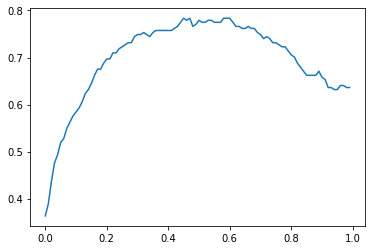

In [91]:
# Yüzdesel Oranlar
y_probs = pd.DataFrame(catb_tuned.predict_proba(X_test))
max = []
for j in np.arange(0,1,0.01):
  y_pred = np.array([1 if i > j else 0 for i in list(y_probs[1])])
  max.append([j ,accuracy_score(y_test, y_pred)])

max = np.array(max)

# Plot
import seaborn as sns
sns.lineplot(y=max[:,1], x=max[:,0])

# Plot

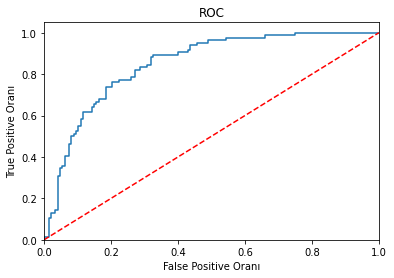

In [92]:
logit_roc_auc = roc_auc_score(y_test, catb_tuned.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, catb_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()